## **Vector Autoregression**

Here we fit a vector autogression model to monthly sales data for domestic automobiles, light trucks, and heavy trucks, with the goal of producing accurate forecasts for future months. An autogressive model predicts future values as a linear combination (essentially a weighted sum) of previous values. The model finds the coefficients (i.e. weights) that minimize the mean squared error between the actual and predicted values over some period of time.    

The "vector" in vector autoregression means the model predicts future values for multiple different series simultaneously, based on past values of not just an individual series, but on past values of all the series included in the data.

Autoregressive models are among the simplest methods in use for forecasting, and they provide a baseline against which more complicated models can be compared.

In [93]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [94]:
# Set up connection to SQL database and read in timeseries data
import pyodbc
from sql_config import *

connection_string = f"""Driver={driver};
Server={server},1433;
Database={database};
Uid={user};Pwd={password};
Encrypt=yes;
"""

conn = pyodbc.connect(connection_string)

query= """
SELECT *
FROM dbo.TimeSeries
"""

series_df = pd.read_sql(query, con=conn, index_col='date')
series_df.head()

C:\Users\test\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Domestic Autos,Domestic Light Trucks,Foreign Autos,Foreign Light Trucks,Heavy Trucks,Gas Price
date,,,,,,
1967-01-01,7.837,1.235,0.629,None,0.359,None
1967-02-01,6.85,1.138,0.69,None,0.304,None
1967-03-01,7.22,1.237,0.74,None,0.359,None
1967-04-01,8.164,1.204,0.746,None,0.343,None
1967-05-01,7.961,1.184,0.782,None,0.344,None


In [95]:
domestics_df = series_df[['Domestic Autos', 'Domestic Light Trucks', 'Heavy Trucks']].dropna()
domestics_df.index = pd.to_datetime(domestics_df.index)
domestics_df = domestics_df.apply(pd.to_numeric)

domestics_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668 entries, 1967-01-01 to 2022-08-01
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Domestic Autos         668 non-null    float64
 1   Domestic Light Trucks  668 non-null    float64
 2   Heavy Trucks           668 non-null    float64
dtypes: float64(3)
memory usage: 20.9 KB


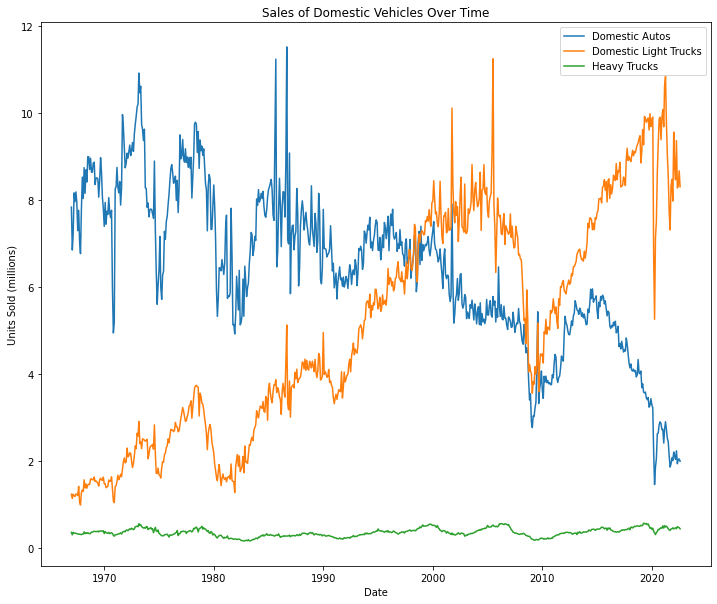

In [96]:
plt.figure(figsize=(12, 10))
for col in domestics_df.columns:
    plt.plot(domestics_df[col], label=col)
    
plt.ylabel("Units Sold (millions)")
plt.xlabel("Date")
plt.title("Sales of Domestic Vehicles Over Time")
plt.legend()
plt.show()

In [97]:
# Check for stationarity, we probably don't have it
def check_stationarity(series, alpha=0.5):
    res = adfuller(series)
    print(f"test-statistic: {res[0]}")
    print(f"p-value: {res[1]}")
    print(f"Significance: {'Significant' if res[1] < alpha else 'Not Significant'}")

for col in domestics_df.columns:
    print(f"Augmented Dicky-Fuller Test of {col}")
    print("====================================")
    check_stationarity(domestics_df[col])
    print("")

Augmented Dicky-Fuller Test of Domestic Autos
test-statistic: -1.1496183181649036
p-value: 0.694884838162895
Significance: Not Significant

Augmented Dicky-Fuller Test of Domestic Light Trucks
test-statistic: -1.0500020843747802
p-value: 0.7345934216014979
Significance: Not Significant

Augmented Dicky-Fuller Test of Heavy Trucks
test-statistic: -3.3614934755413675
p-value: 0.012343726408697322
Significance: Significant



In [98]:
# Two of three series not significant, take 1st difference and check again
domestics_difference = domestics_df.diff().dropna()

for col in domestics_difference.columns:
    print(f"Augmented Dicky-Fuller Test of {col}")
    print("====================================")
    check_stationarity(domestics_difference[col])
    print("")

Augmented Dicky-Fuller Test of Domestic Autos
test-statistic: -6.893941224982473
p-value: 1.3336914965211743e-09
Significance: Significant

Augmented Dicky-Fuller Test of Domestic Light Trucks
test-statistic: -8.141602930823264
p-value: 1.0246257368959176e-12
Significance: Significant

Augmented Dicky-Fuller Test of Heavy Trucks
test-statistic: -33.4203838605854
p-value: 0.0
Significance: Significant



In [100]:
# Stationary now; split into train and test sets, select model order, and fit
train_split = int(0.8*len(domestics_difference))
train_df = domestics_difference[:train_split]

train_model = VAR(train_df)
train_model.select_order().summary()

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-10.59,-10.57,2.507e-05,-10.58
1,-10.73,-10.63,2.189e-05,-10.69
2,-10.87,-10.70,1.904e-05,-10.80
3,-10.97,-10.73*,1.715e-05,-10.88*
4,-10.99*,-10.67,1.690e-05*,-10.86
5,-10.97,-10.58,1.713e-05,-10.82
6,-10.96,-10.49,1.731e-05,-10.78
7,-10.97,-10.42,1.726e-05,-10.75
8,-10.94,-10.33,1.766e-05,-10.70
9,-10.93,-10.24,1.784e-05,-10.66


In [101]:
# AIC picks 4 lags, use that
fitted = train_model.fit(4, ic='aic', trend='n')
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Sep, 2022
Time:                     12:44:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.7413
Nobs:                     529.000    HQIC:                  -10.9182
Log likelihood:           702.104    FPE:                1.61764e-05
AIC:                     -11.0320    Det(Omega_mle):     1.51236e-05
--------------------------------------------------------------------
Results for equation Domestic Autos
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
L1.Domestic Autos               -0.351812         0.050841           -6.920           0.000
L1.Domestic Light Trucks         0.004415         0.081245            0.054           0.957
L1.Heav

In [102]:
# get predicted diffs
pred_model = VAR(domestics_difference)
pred_diffs = pred_model.predict(fitted.params, lags=4, trend='n')

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [103]:
# Rolling back the differencing operation to get final predictions
# Predicted sales in a month are the predicted difference in a month, plus the actual sales in the month prior

prior_month_vals = domestics_df[4:-1].values
final_pred_values = prior_month_vals + pred_diffs

# Start index at 6th month because we lost the 1st to differencing, and the next 4 to the model
final_pred_df = pd.DataFrame(final_pred_values, columns=domestics_df.columns, index=domestics_df.index[5:])
final_pred_df.head()

,Domestic Autos,Domestic Light Trucks,Heavy Trucks
date,,,
1967-06-01,7.660606,1.178861,0.346173
1967-07-01,7.955901,1.264380,0.341589
1967-08-01,7.770345,1.184444,0.331352
1967-09-01,7.609362,1.231295,0.323326
1967-10-01,7.890420,1.324001,0.319332


Out-of-Sample Performance: Domestic Autos


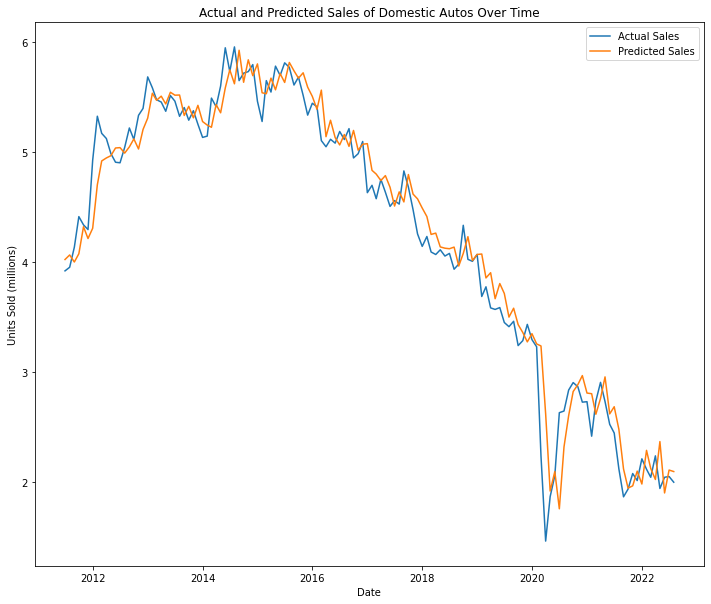

Out-of-Sample RMSE: 0.250
Out-of-Sample MAPE: 0.052

Out-of-Sample Performance: Domestic Light Trucks


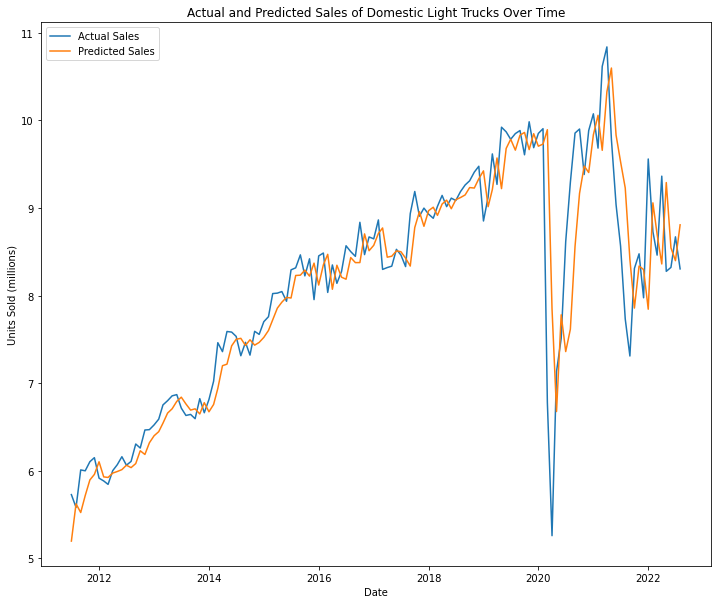

Out-of-Sample RMSE: 0.561
Out-of-Sample MAPE: 0.042

Out-of-Sample Performance: Heavy Trucks


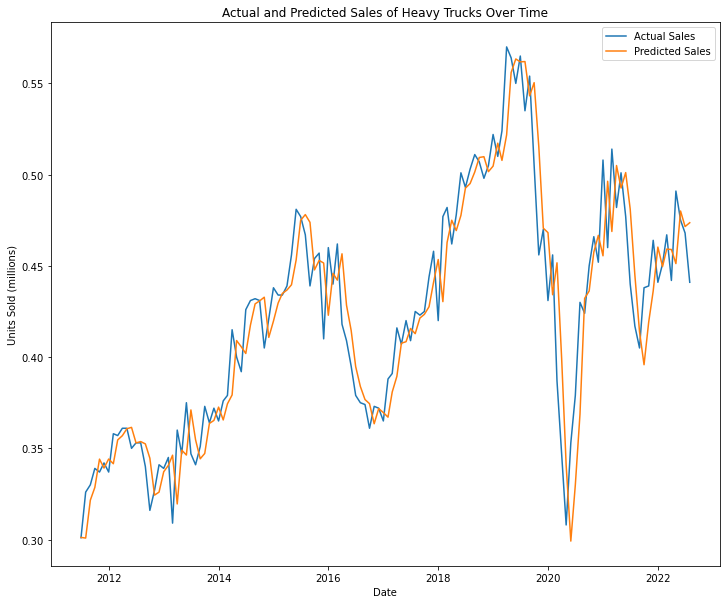

Out-of-Sample RMSE: 0.023
Out-of-Sample MAPE: 0.042



In [104]:
# So indices align with real data, glue the first 5 actual months onto the predictions df
convenient_df = pd.concat([domestics_df.head(5), final_pred_df])
test_df = domestics_df[train_split+1:]
oos_pred = convenient_df[train_split+1:]

# Assess out-of-sample performance
def assess_oos_performance(true_vals, pred_vals):
    print(f"Out-of-Sample RMSE: {mean_squared_error(true_vals, pred_vals)**0.5:.3f}")
    print(f"Out-of-Sample MAPE: {mean_absolute_percentage_error(true_vals, pred_vals):.3f}")
    
for col in test_df.columns:
    print(f"Out-of-Sample Performance: {col}")
    print("==========================="+"="*len(col))
    
    plt.figure(figsize=(12, 10))
    plt.plot(test_df[col], label="Actual Sales")
    plt.plot(oos_pred[col], label="Predicted Sales")
    plt.xlabel("Date")
    plt.ylabel("Units Sold (millions)")
    plt.title(f"Actual and Predicted Sales of {col} Over Time")
    plt.legend()
    plt.show()
    
    assess_oos_performance(test_df[col], oos_pred[col])
    print("")

**Results**

We assess model performance by examining two metrics on data the model has never seen before. The first metric is root mean squared error, or RMSE, which is a kind of average error. As the scales of the three series are different, we also examine the mean absolute percentage error, or MAPE, which looks at the average percentage difference between the actual and predicted values.

The model performed similarly for all three series, with a MAPE of approximately 4-5%, rendering these forecasts useable, but imperfect. The model performs best on the heavy trucks category, likely as a result of this series being most steady. In turn, the model struggled the most predicting domestic automobile sales , with a MAPE of just over 5% on new data. This market segment exhibits the most volatility during the training span of the data, which makes it harder for the model to learn the values of the coefficients.

**Impact of COVID**

In all three series the model particularly struggles with the sudden downturn in sales caused by the COVID pandemic, as well as the subsequent upswing. To get a truer sense of model performance, as well as to underscore the disruptions of COVID, we zoom in on the model performance in the pre-COVID portions of the test set

In [105]:
no_covid_test_df = test_df[:-30]
no_covid_oos_pred = oos_pred[:-30]

for col in no_covid_test_df.columns:
    print(f"Pre-COVID OOS Model Performance: {col}")
    print("================================="+"="*len(col))
    assess_oos_performance(no_covid_test_df[col], no_covid_oos_pred[col])
    print("")

Pre-COVID OOS Model Performance: Domestic Autos
Out-of-Sample RMSE: 0.200
Out-of-Sample MAPE: 0.033

Pre-COVID OOS Model Performance: Domestic Light Trucks
Out-of-Sample RMSE: 0.233
Out-of-Sample MAPE: 0.023

Pre-COVID OOS Model Performance: Heavy Trucks
Out-of-Sample RMSE: 0.019
Out-of-Sample MAPE: 0.034



We see drastic reductions in prediction error for all three vehicle categories

# **Alternative Models**

We would like to improve performance on the VAR model above. Unlike other algorithms, vector autoregression has very few hyperparameters to tune except for the number of lags to include. However, this parameter is typically not selected via search, but rather by examining metrics such as the Aikake Information Criterion, as we have done. Therefore, rather than trying to tune the number of lags, which is unlikely to improve performance, the more natural thing for us to do is to consider alternative model specifications.

While we chose a VAR model as it seemed likely that sales in one category would affect future sales in another, examining the coefficients it seems that many cross-category coefficients are either small, statistically insignificant, or both. It's worth checking, then, to see if a series of individual AR(p) models performs better on the test data, as the smaller number of coefficients means there is a reduced potential for overfitting.

In [106]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [107]:
train_models = {}
for col in train_df.columns:
    train_models[col] = {}
    train_models[col]['lags'] = ar_select_order(train_df[col], maxlag=30, trend='n').ar_lags
    train_models[col]['model'] = AutoReg(train_df[col], lags=train_models[col]['lags'], trend='n').fit()
    print(train_models[col]['model'].summary(), "\n")

                            AutoReg Model Results                             
Dep. Variable:         Domestic Autos   No. Observations:                  533
Model:                     AutoReg(4)   Log Likelihood                -460.179
Method:               Conditional MLE   S.D. of innovations              0.578
Date:                Fri, 30 Sep 2022   AIC                            930.358
Time:                        12:44:33   BIC                            951.713
Sample:                    06-01-1967   HQIC                           938.717
                         - 06-01-2011                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Domestic Autos.L1    -0.3538      0.043     -8.218      0.000      -0.438      -0.269
Domestic Autos.L2    -0.4097      0.045     -9.162      0.000      -0.497      -0.322
Domestic Autos.L3    -0.

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

                              AutoReg Model Results                              
Dep. Variable:     Domestic Light Trucks   No. Observations:                  533
Model:                        AutoReg(3)   Log Likelihood                -218.369
Method:                  Conditional MLE   S.D. of innovations              0.365
Date:                   Fri, 30 Sep 2022   AIC                            444.737
Time:                           12:44:34   BIC                            461.829
Sample:                       05-01-1967   HQIC                           451.427
                            - 06-01-2011                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Domestic Light Trucks.L1    -0.3673      0.042     -8.739      0.000      -0.450      -0.285
Domestic Light Trucks.L2    -0.2960      0.043     -6.864      0.

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [108]:
# Generate predictions for each series individually, as the number of lags is different
# glue them back together into one dataframe
# AutoReg.predict can return a dataframe, unlike VAR.predict above
# Chose not to take advantage of this in order to reuse earlier code without much modification

series_pred_dict = {}

for col in domestics_difference.columns:
    num_lags = len(train_models[col]['lags'])
    pred_model = AutoReg(domestics_difference[col], lags=train_models[col]['lags'], trend='n')
    pred_diffs = pred_model.predict(train_models[col]['model'].params).dropna().values
    
    prior_month_vals = domestics_df[col][num_lags:-1].values
    series_pred_vals = prior_month_vals + pred_diffs
    
    series_pred_dict[col] = pd.Series(series_pred_vals, index=domestics_df.index[num_lags+1:])

glued_pred_df = pd.concat([series for series in series_pred_dict.values()], axis=1)
glued_pred_df.columns = domestics_df.columns

glued_pred_df.head()

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Domestic Autos,Domestic Light Trucks,Heavy Trucks
date,,,
1967-03-01,NaN,NaN,0.317612
1967-04-01,NaN,NaN,0.345388
1967-05-01,NaN,1.211446,0.346960
1967-06-01,7.704391,1.175979,0.343753
1967-07-01,7.935170,1.233728,0.337227


Out-of-Sample Performance: Domestic Autos


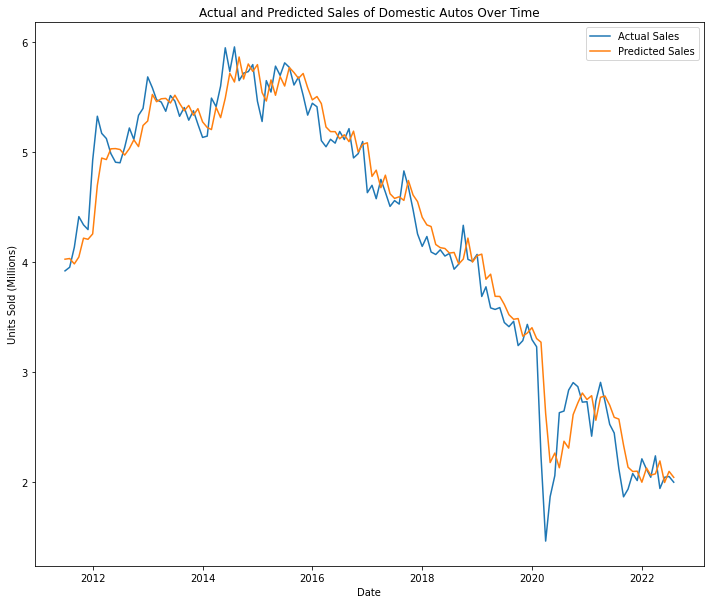

Out-of-Sample RMSE: 0.247
Out-of-Sample MAPE: 0.051

Out-of-Sample Performance: Domestic Light Trucks


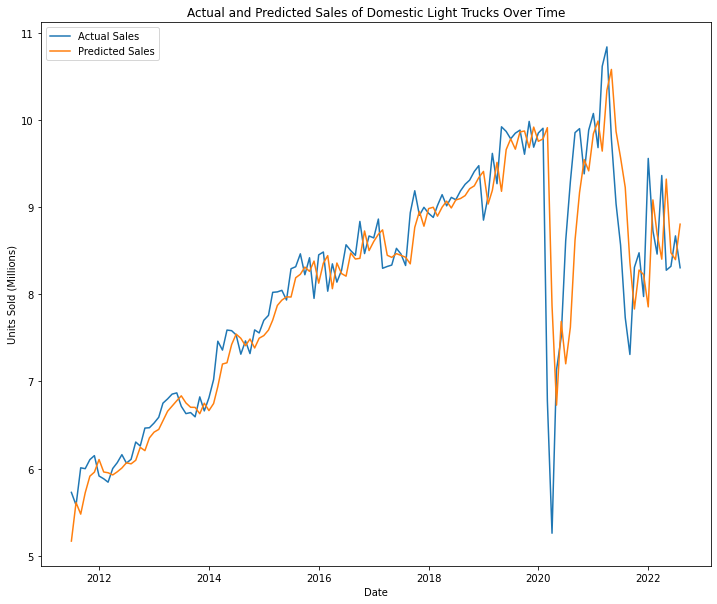

Out-of-Sample RMSE: 0.563
Out-of-Sample MAPE: 0.042

Out-of-Sample Performance: Heavy Trucks


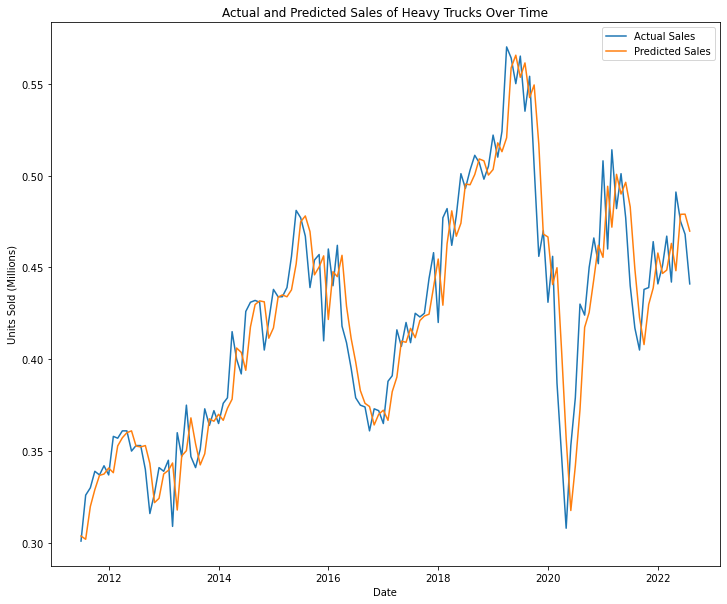

Out-of-Sample RMSE: 0.023
Out-of-Sample MAPE: 0.042



In [109]:
# Make another convenience df, just so all indices align on data and predictions
convenient_df2 = pd.concat([domestics_df.head(2), glued_pred_df])
oos_pred2 = convenient_df2[train_split+1:]

for col in test_df.columns:
    print(f"Out-of-Sample Performance: {col}")
    print("==========================="+"="*len(col))
    
    plt.figure(figsize=(12, 10))
    plt.plot(test_df[col], label='Actual Sales')
    plt.plot(oos_pred2[col], label="Predicted Sales")
    plt.xlabel("Date")
    plt.ylabel("Units Sold (Millions)")
    plt.title(f"Actual and Predicted Sales of {col} Over Time")
    plt.legend()
    plt.show()
    
    assess_oos_performance(test_df[col], oos_pred2[col])
    print("")

**Results**

The series of individual AR(p) models performs at pretty much the same level as the vector autogression, confirming our suspicion that the monthly sales across categories are not strongly co-integrated, but disappointing our hopes that a reduced potential for overfitting might result in better performance.

Again as above each model struggles particularly with the downturn produced by the COVID pandemic. One future avenue for improvement would be to use a robust regression algorithm, rather than OLS, in estimating the model coefficients, as the distribution of errors is almost assuredly heavy-tailed. Another avenue, which we pursue elsewhere in this project, is to use a different class of model, in our case an LSTM neural network. 